In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Preprocess the dataset
temperatures = data['Temp'].values.reshape(-1, 1)

In [3]:

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_temperatures = scaler.fit_transform(temperatures)

In [4]:
n_test_years = 3
test_size = n_test_years * 365  # number of days in 3 years
train_data = normalized_temperatures[:-test_size]
test_data = normalized_temperatures[-test_size:]

In [5]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

In [6]:
from jonigrad.layers import Module, Linear, LSTM, ReLU

# Define the LSTM model
class LSTMModel(Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = LSTM(input_size, hidden_layer_size)
        self.linear = Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _, _ = self.lstm.forward(input_seq)
        predictions = self.linear(lstm_out[:, -1])
        return predictions

    def backward(self, dL_dy):
        dL_dy = self.linear.backward(dL_dy)
        dL_dy = np.expand_dims(dL_dy, 2)
        dl_dx = self.lstm.backward(dL_dy)
        return dl_dx
    
class LinearModel(Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.fc1 = Linear(input_size, 256)
        self.fc2 = Linear(256, 128)
        self.fc3 = Linear(128, output_size)
        self.relu1 = ReLU()
        self.relu2 = ReLU()

    def forward(self, input_seq):
        y = self.relu1.forward(self.fc1.forward(input_seq))
        y = self.relu2.forward(self.fc2.forward(y))
        y = self.fc3.forward(y)
        return y

    def backward(self, dL_dy):
        dL_dy = self.fc3.backward(dL_dy)
        dL_dy = self.relu2.backward(dL_dy)
        dL_dy = self.fc2.backward(dL_dy)
        dL_dy = self.relu1.backward(dL_dy)
        dl_dx = self.fc1.backward(dL_dy)
        return dl_dx


100%|██████████| 1000/1000 [00:05<00:00, 182.11it/s]


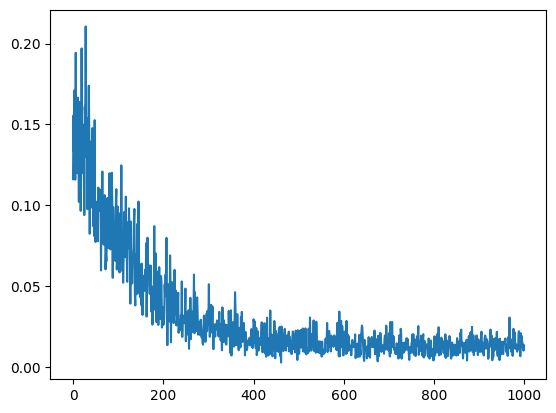

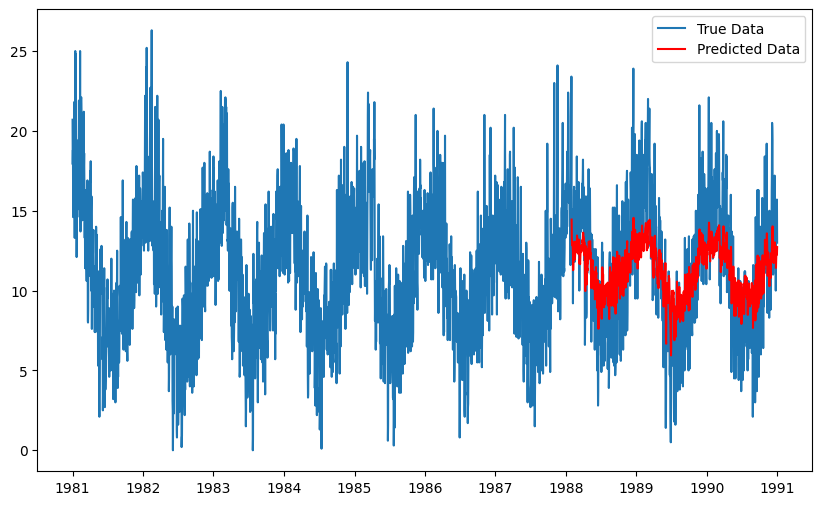

In [12]:
from jonigrad.layers import MSELoss
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1)
# model = LinearModel(input_size=30, hidden_layer_size=50, output_size=1)
loss_function = MSELoss()

ITERS = 1000
BATCH_SIZE = 16
LR = 0.001
g = np.random.default_rng()

model.train()
losses = []
for iter in tqdm(range(ITERS)):
    ix = g.integers(low=0, high=x_train.shape[0], size=BATCH_SIZE)
    Xb, Yb = x_train[ix], y_train[ix]
    
    # Xb = Xb.reshape(BATCH_SIZE, -1)
    y_pred  = model(Xb)
    loss = loss_function(y_pred, Yb)
    model.zero_grad()
    dL_dy = loss_function.backward()
    model.backward(dL_dy)
    model.step(LR)
    losses.append(loss.item())

plt.plot(losses)
plt.show()

# Make predictions on the test set
model.eval()
predictions = []
for i in range(len(x_test)):
    # seq = x_test[i].reshape(1, 30)
    seq = np.expand_dims(x_test[i],0)  # add batch dimension
    prediction = model(seq)
    predictions.append(prediction.item())

# Denormalize the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Denormalize the actual test values
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Generate dates for the test data
test_dates = data.index[-test_size + seq_length:]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data.index, temperatures, label='True Data')
plt.plot(test_dates, predictions, label='Predicted Data', color='red')
plt.legend()
plt.show()